## A reverse engineering exploration of Deep Learning (DNN)##
### Prapanch Nair ,###
#### Institute for Multiscale Simulations ####

### Introduction ###
In engineering applications there is often some insight available about the data (features and labels) that is used to train a deep neural network (DNN) model. A lot can be learned about the behavior of DNN designs by simply generating random data and complex non-linear function of the features as labels. This kind of exploration is rare among the hundreds of well written blogs available on the internet. Most of them take data from a particular domain (such as cat images or vehicle mileage), to illustrate machine learning but do not delve into what mathematical functions are actualy being approximated. Such insights would help us tackle issues we face with model architecture. This jupyter notebook tries to bridge this gap and can of course be used as a framework for you to explore further. 

We are first going to generate random data with a uniform distribution as features for our training. We then create a label (dependent variable) as a function of the data. The goal is to understand and appreciate what kinds of functions can be learned easily and what kind of functions make it extremely difficult. Machine learning examples such as predicting land values and classifying cats are indeed complex, but fitting a model does not help us appreciate how complex these problems are in the first place. In most problems, domain experts have intuitions about how the features may be affecting the label. Hypotheses about those functional relationships are important to understand why the ML algorithms perform the way they do. 

### Generate uniformly random data ###
Following code simply generates random data:

In [20]:
import pathlib
import matplotlib.pyplot as pl
import numpy as np
np.random.seed(0)
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
N=5000 # Number of samples
X = np.random.rand(N,6)


We have six features ($x1,x2,...,x6$) and 5000 samples for training and testing for this exercise. Why did we choose these numbers? Let's say we have only one variable $x1$. To predict a linear function $y = mx+c$, we need at least two data points. But real data would be noisy and we may over or under-predict. However, we would at least need 2 data points to get some fit in the first place. If we had two features, $x1$ and $x2$ we would need, for each $x1_i$, 2 $x2$'s to get a linear relationship fit. This means we need at least $2^2$ data points. We could generalize this to say that if we have $M$ features, the minimum (bare minimum) number of data we would need for a linear fit is $2^M$. In our case we would only need 64 data points for a linear relationship assuming our data collection was clean and there is in fact a strictly linear dependence of the label on the features. 

Suppose we are worried about the noise and a slight non-linearity. We may need 3 (for any non-linearity to be captured) or 4 points to account for some noise. The number of data points required would be $4^M = 4096$. Now you begin to see why the number 5000 is sort of a minimum required data size. Of course, here we assume that the data is spread well enough. In mathematical terms we can call the features as dimensions of data, in other words, a $M$ dimensional vector space. The set of data points should be in the **range** of the data. What does range mean? Let us see an example: look at the data sets that have four data points each, below. While the plot on the right shows data that is representative of both $X1$ and $X2$, the plot on the left shows data that represents only $X1$ well, as most of the data is along $x2$. 



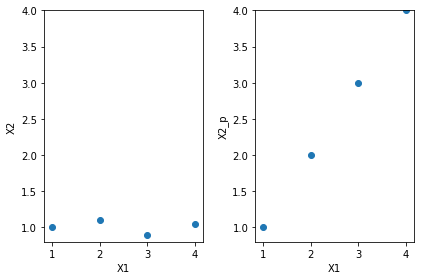

In [21]:
X_first=np.array([1,2,3,4]); X_second=np.array([1,1.1,0.9,1.05]);X_second_p  =np.array([1,2,3,4])
pl.subplot(121); pl.scatter(X_first,X_second);pl.xlabel("X1");pl.ylabel("X2");pl.ylim(0.8,4)
pl.subplot(122); pl.scatter(X_first,X_second_p);pl.xlabel("X1");pl.ylabel("X2_p");pl.ylim(0.8,4);pl.tight_layout()

As we mentioned earlier let us generate a label ($Y$) such that we know the relationship between the features and label and yet checking if our Deep learning model would fit this as a regression problem. Also we would like to see the cross correlation of all these data variable between each other and their probability density function. We use the tool called pairplot from seaborn to do this.

shape of data is:  (5000, 7)


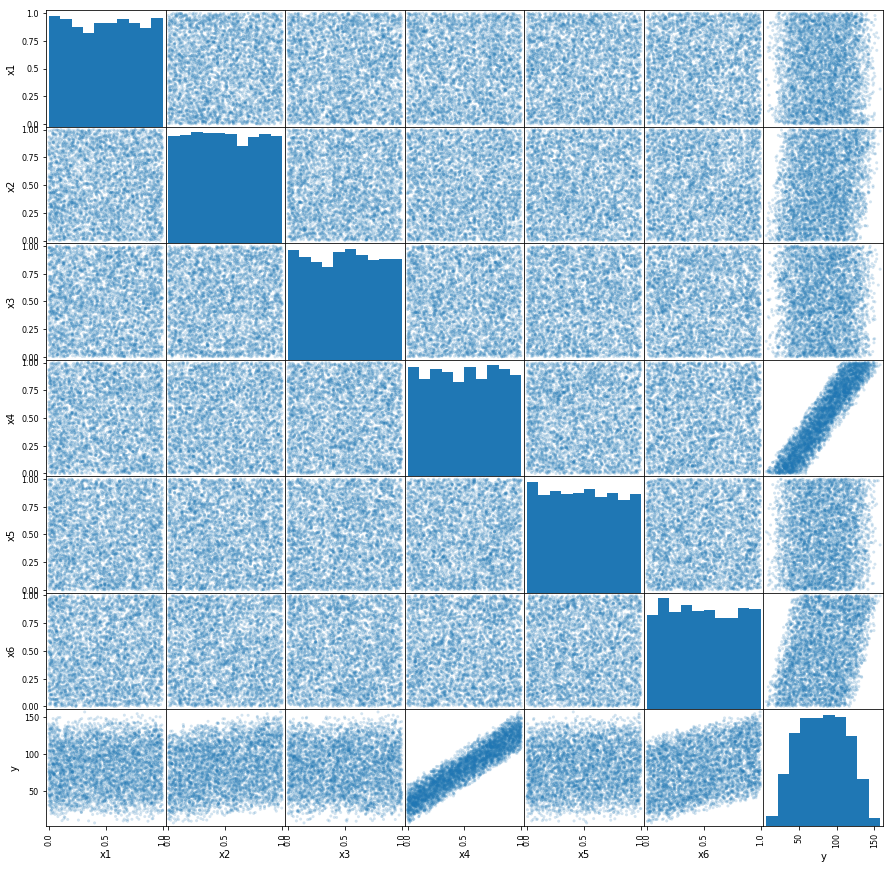

                x1           x2           x3           x4           x5  \
count  4750.000000  4750.000000  4750.000000  4750.000000  4750.000000   
mean      0.498413     0.496963     0.498122     0.500727     0.491812   
std       0.292271     0.289479     0.289081     0.289988     0.289679   
min       0.000424     0.000254     0.000345     0.000074     0.000072   
25%       0.239592     0.248310     0.244791     0.247718     0.245464   
50%       0.501947     0.492787     0.503174     0.504913     0.490865   
75%       0.751109     0.753102     0.746872     0.754555     0.740837   
max       0.999962     0.999964     0.999809     0.999978     0.999949   

                x6            y  
count  4750.000000  4750.000000  
mean      0.495703    81.810953  
std       0.289314    31.436378  
min       0.000207     7.396713  
25%       0.245434    56.870884  
50%       0.488854    81.966371  
75%       0.749474   107.162518  
max       0.999957   157.450311  


In [22]:
Y = X[:,0]+ 2.0*X[:,2]+ 20.0*X[:,1] +  100.0*X[:,3] +36.0*(X[:,5]) + 5.0*X[:,4]
Y = Y[:,np.newaxis]
data = np.hstack((X,Y))
print("shape of data is: ",np.shape(data))
column_names = [ 'x1','x2','x3','x4','x5','x6','y']
df = pd.DataFrame(data, columns =column_names)
dataset = df.copy()
dataset.tail()
dataset.isna().sum()
dataset.tail()

train_dataset = dataset.sample(frac=0.95,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
#sns.pairplot(train_dataset[['x1','x2','x3','x4','x5','x6','y']])
#pl.figure(figsize=(30,40))
pd.plotting.scatter_matrix(train_dataset,alpha=0.2,figsize=(15,15))
pl.show()
train_stats = train_dataset.describe()
print(train_stats)


Couple of questions now: 
1. Why did I use data in the range $(0,N)$? Only because it is well known that neural networks perform well for this data range. Any given features can be scaled in this range. 
2. Why use a uniform random distribution and not a gaussian (normal) distribution? No particular reason. 
3. Why use training data for our statistics? Because that is what we strictly use to train.

Note that $Y$ has a normal distribution. 

Now we build a NN model with only one output node (and one more optional node for scaling). We write this function in such a way that additional layers and nodes can be configured later on. 

In [23]:

# seggregate Y as a label for the model. 
train_copy = train_dataset.copy() #make a copy for backup
train_labels = train_dataset.pop('y')
test_labels = test_dataset.pop('y')

def norm(x):
    return (x - train_stats['min'])/(train_stats['max']-train_stats['min']) # a redundant step 
                                                                            # since our data is scaled 
                                                                            # at initialization
normed_train_data = (train_dataset)
normed_test_data = (test_dataset)

# Function to build the model based on input configurations for the NN, supplied through 
# a dictionary called "options"
def build_model(options):
    model = keras.Sequential([
        # First layer (becomes output layer for a logistic regression problem)
        layers.Dense(options['layers'][0], activation=options['Activation'], input_shape=[len(train_dataset.keys())]),
    ])
    # For hidden layers suppied by the "layers" array in the options dictionary
    for l in options['layers'][1:]:
        model.add(layers.Dense(l, activation=options['Activation']))
    # One single node layer with linear activation for any required scaling.
    model.add(layers.Dense(1))
    # to use different optimizers, learning rate, loss functions     
    if(options['optimizer']=='Adam'):
        optimizer = tf.keras.optimizers.Adam(options['lr'])
    elif(options['optimizer']=='rmsprop'):
        optimizer = tf.keras.optimizers.RMSprop(options['lr'])
    elif(options['optimizer']=='SGD'):
        optimizer = tf.keras.optimizers.SGD(lr=options['lr'])
    else:
        optimizer = tf.keras.optimizers.RMSprop(options['lr'])
    model.compile(loss = options['lossfunc'],
                 optimizer = optimizer,
                 metrics=['mean_absolute_error','mean_squared_error'])
    return model

# Defining our options for the model
# layers is an array with nodes per layer: 'layers':[l1,l2, ...]
# In this case we use only one node (checking if our linear function is predicted easily)
options = {'optimizer':'SGD', 'lossfunc':'mean_squared_error','Activation':'relu','layers':[1],'lr':0.01}
model= build_model(options)
model.summary()



In [24]:
# Display training progress by printing a single dot for every 100 completed epochs
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 1000 == 0: print(''+str(epoch))
    if epoch % 100==0: print('.', end='')

EPOCHS = 10000 #We will use callback functions for early termination.
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(),
             # reduce learning rate when model doesn't improve
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=0, mode='auto', min_delta=0.0001, cooldown=20, min_lr=0),
             # stop when model doesn't improve for 100 epochs
             keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None)])
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#hist.tail()

0
..........1000
..........2000
..........3000
..........4000
..........5000
.......

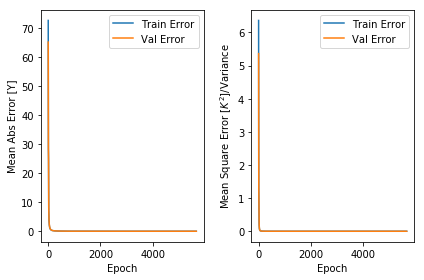

In [25]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  pl.subplot(1,2,1)
  pl.xlabel('Epoch')
  pl.ylabel('Mean Abs Error [Y]')
  pl.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  pl.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #pl.ylim([0,5])
  pl.legend()
  
  pl.subplot(1,2,2)
  pl.xlabel('Epoch')
  pl.ylabel('Mean Square Error [$K^2$]/Variance')
    # We scale the mean squared error with the variance in the label 
    # so there is a sense of the error with respect to the initial 
    # spread of data
  pl.plot(hist['epoch'], hist['mean_squared_error']/std_Y**2,
           label='Train Error')
  pl.plot(hist['epoch'], hist['val_mean_squared_error']/std_Y**2,
           label = 'Val Error')
  pl.legend()
  pl.tight_layout()

#storing the deviation in the values of Y for reference. 
std_Y = train_labels.std()
plot_history(history)

## Linear function results ##

Thus we now have a model that predicts a linear function quite easily, with a single node. Any constant coefficients can be given to the features in the linear combination and you will see that this NN performs really well and the training and test data drops close to zero in a few hundred training epochs. 

## Non-linear functions ##
Now lets have some fun with the Y function. Make it non-linear and check if we can train with ease. 
For this we only change the label data. 


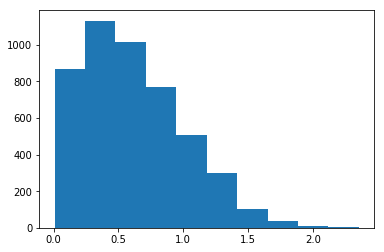

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 7         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 2         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
0
..........1000
........

In [26]:
# previous (linear) function
#Y = X[:,0]+ 2.0*X[:,2]+ 20.0*X[:,1] +  100.0*X[:,3] +36.0*(X[:,5]) + 5.0*X[:,4]
# A non-linear function
df['y']=df['x1']*df['x2']+df['x3']**3+df['x4']*df['x5']*df['x6'] 

train_dataset = df.sample(frac=0.95,random_state=0)
test_dataset = df.drop(train_dataset.index)
#pd.plotting.scatter_matrix(train_dataset,alpha=0.2,figsize=(15,15))
pl.hist(train_dataset['y'])
pl.show()
train_labels = train_dataset.pop('y')
test_labels = test_dataset.pop('y')
# We introduce 1 hidden layer as you can check that if you comment the below line,
# the error wouldn't decrease.
options['layers'] = [6,1]
model= build_model(options)
model.summary()
history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(),
             # reduce learning rate when model doesn't improve
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=0, mode='auto', min_delta=0.0001, cooldown=20, min_lr=0),
             # stop when model doesn't improve for 100 epochs
             keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None)])
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#hist.tail()

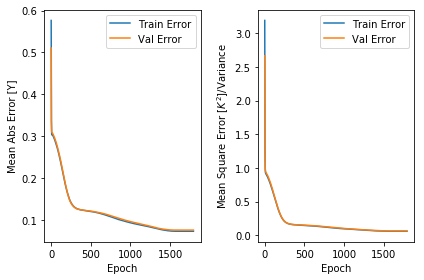

In [27]:
std_Y = train_labels.std()
plot_history(history)

#### With a single hidden layer we were able to capture that non-linear function ####
Time to make it even harder for our NN. We can do this simply by making a small modification. Introduce a negative power. In the following function we change the power of $x6$ to $-1$

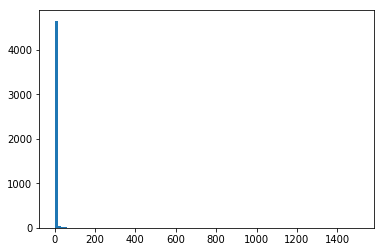

In [28]:
# previous (linear) function
#Y = X[:,0]+ 2.0*X[:,2]+ 20.0*X[:,1] +  100.0*X[:,3] +36.0*(X[:,5]) + 5.0*X[:,4]
# A non-linear function
df['y']=df['x1']*df['x2']+df['x3']**3+df['x4']*df['x5']/df['x6'] 

train_dataset = df.sample(frac=0.95,random_state=0)
test_dataset = df.drop(train_dataset.index)
pl.hist(train_dataset['y'],bins=100)
pl.show()

The distribution of our label data now looks very far from normal. Lets see how this affects our training. 

In [29]:

train_labels = train_dataset.pop('y')
test_labels = test_dataset.pop('y')
# We introduce 1 hidden layer as you can check that if you comment the below line,
# the error wouldn't decrease.
options['layers'] = [6,1]
model= build_model(options)
model.summary()
history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(),
             # reduce learning rate when model doesn't improve
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=0, mode='auto', min_delta=0.0001, cooldown=20, min_lr=0),
             # stop when model doesn't improve for 100 epochs
             keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None)])
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#hist.tail()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 7         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 2         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
0
....

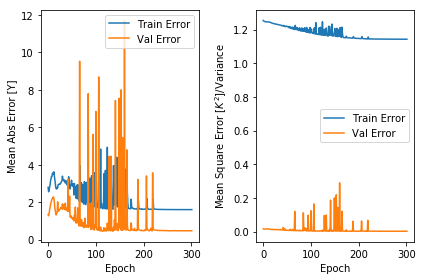

In [30]:
std_Y = train_labels.std()
plot_history(history)

What shall we do to improve this situation? To understand this, lets plot the data once more!
Also note that the validation error seems to be low from the beginning. This is because the label data with outliers is very inconsistent. It is extrememly difficult to split the validation dataset and training dataset to have same statistics for such data. In the following section, we have a fix for this. 


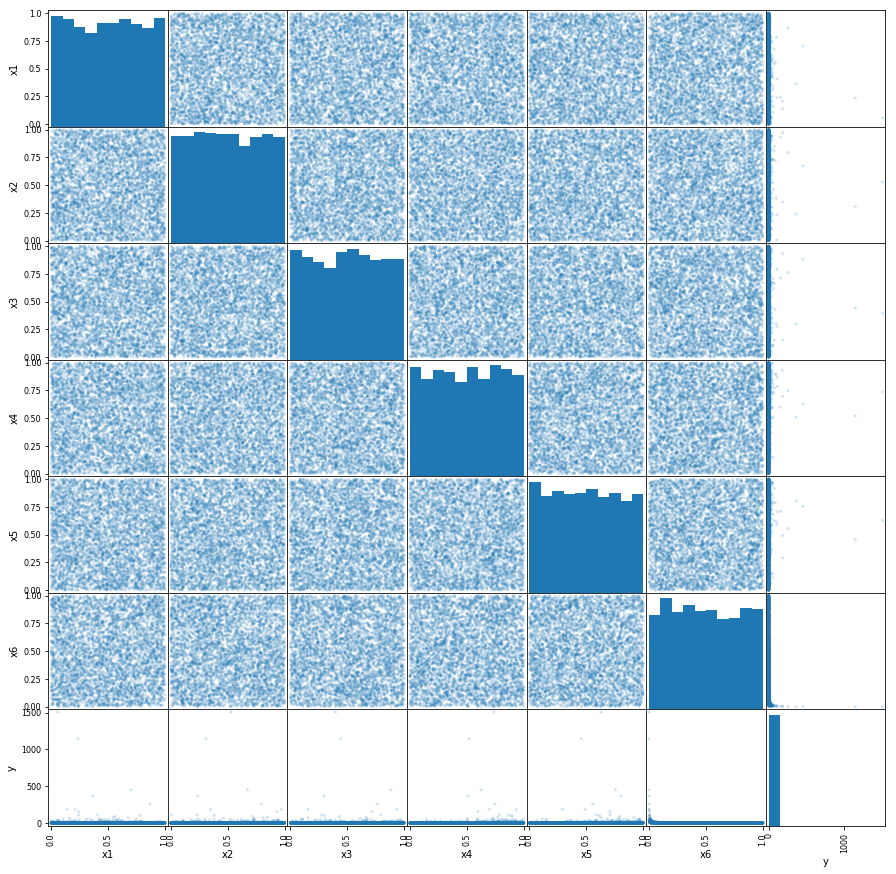

In [31]:
df['y']=df['x1']*df['x2']+df['x3']**3+df['x4']*df['x5']/df['x6'] 

train_dataset = df.sample(frac=0.95,random_state=0)
test_dataset = df.drop(train_dataset.index)
pd.plotting.scatter_matrix(train_dataset,alpha=0.2,figsize=(15,15))
pl.show()

Due to the negative powers of $x6$, the label data is now spanning orders of magnitude. In many engineering applications, this may be the case.  
What is the solution? We take the logarithm of our label and see.


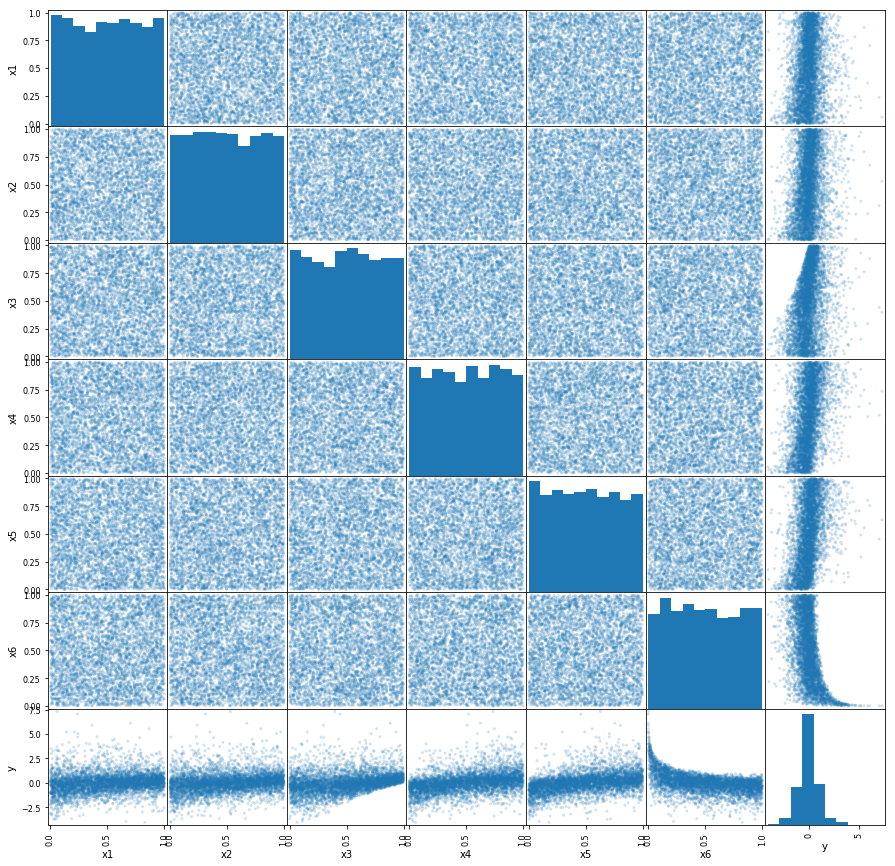

In [35]:
df['y']=np.log(df['x1']*df['x2']+df['x3']**3+df['x4']*df['x5']/df['x6'] )

train_dataset = df.sample(frac=0.95,random_state=0)
test_dataset = df.drop(train_dataset.index)
pd.plotting.scatter_matrix(train_dataset,alpha=0.2,figsize=(15,15))
pl.show()

Viola! We get the normal distribution of our label data back. Let us try to train our model once more. 

In [36]:
train_labels = train_dataset.pop('y')
test_labels = test_dataset.pop('y')
# We introduce 1 hidden layer as you can check that if you comment the below line,
# the error wouldn't decrease.
options['layers'] = [6,1]
model= build_model(options)
model.summary()
history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(),
             # reduce learning rate when model doesn't improve
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=0, mode='auto', min_delta=0.0001, cooldown=20, min_lr=0),
             # stop when model doesn't improve for 100 epochs
             keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None)])
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#hist.tail()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 7         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 2         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
0
..........1000
..

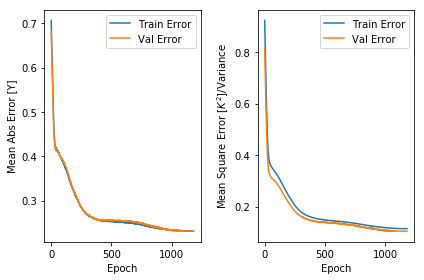

In [37]:
std_Y = train_labels.std()
plot_history(history)

We now have a reasonable model. Exponential relationships are extremely difficult to fit using machine learning. Logarithms of the data is therefore helpful.

Thus the insights we may have on the relationship between the features and the label can be tested through this process of dummy data.